In [ ]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# calling map 
GoldMask = callingEliGoldMask()
GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

Spatial Cut  530537
Spatial Cut  1003503


In [118]:
# calling gold + des catalog
merged_des_st82 = fitsio.read('result_cat/merged_des_st82_nocut.fits') # in stripe82
#merged_des_patch = fitsio.read('result_cat/merged_des_spt_nocut.fits') # spt 0<ra<100, -52<dec<-48
# prior Cut, limit survey depth
#from cmass_modules import Cuts
merged_des_st82_s  = Cuts.doBasicCuts( merged_des_st82 )
#merged_des_patch_s = Cuts.doBasicCuts( merged_des_patch )
merged_des_st82_s, _ = priorCut( merged_des_st82_s )
#merged_des_patch_s, _ = priorCut( merged_des_patch_s )
#merged_des_st82_s = Cuts._keepGoodRegion(merged_des_st82_s)
#merged_des_patch_s = Cuts._keepGoodRegion( merged_des_patch_s)

6372382 1183 7382
do Basic Cut 2122335
prior cut  1116939


In [163]:
# calling im3shape'
from cmass_modules.io import getCatalogsWithKeys
shear = getCatalogsWithKeys(keyword = 'im3shape_st82.fits', path = '/n/des/lee.5922/data/')
shear = shear[shear['INFO_FLAG'] == 0]
#shear = changeColumnName( shear, name = 'RA_AS', rename = 'RA' )
#shear = changeColumnName( shear, name = 'DEC_AS', rename = 'DEC' )
shear = Cuts.keepGoodRegion(shear)
shear = Cuts.SpatialCuts(shear, ra=320, ra2=360 , dec=-2, dec2=2 )

Spatial Cut  2108394


In [46]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
cmass = Cuts.keepGoodRegion(cmass)
cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82_s['RA'], \
                                     merged_des_st82_s['DEC'], 1./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82_s.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82_s[cmass_mask], merged_des_st82_s[~cmass_mask]

Applying Healpix BOSS SGC footprint mask
Spatial Cut  10641


In [3]:
dmass_st82 = fitsio.read('result_cat/dmass_st82_21.fits')
#result_st82 = fitsio.read('result_cat/result_gold_st82_18.fits')

#result_st82 = Cuts.SpatialCuts(result_st82, ra=320, ra2=360, dec=-2, dec2=2)
#dmass_st82, _ = resampleWithPth( result_st82, pstart = 0, pmax = 1.0 )

In [14]:
print cmass.size, clean_cmass_data_des.size, dmass_st82.size

NameError: name 'cmass' is not defined

In [194]:
1/60., 1/60. * 5, 1/60. * 10

(0.016666666666666666, 0.08333333333333333, 0.16666666666666666)

In [35]:

#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
#bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)
bins = np.linspace(0, 1/60. * 200, 201)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

bins_log = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)
#bins = np.linspace(0.0, 1.5, 16)
bin_centers_log = 0.5 * (bins_log[1:] + bins_log[:-1])



#@pickle_results("correlation_functions_DMASS_st82_even.pkl")
def compute_results(data, bins = None, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    #bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)
    #bins = np.linspace(0.0, 1.5, 16)
    Nbins = bins.size
    
    results = [bins]
    #for D in [data_red, data_blue]:
    results += bootstrap_two_point_angular(data['RA'],
                                               data['DEC'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

#(bins, r_corr, r_corr_err, r_bootstraps,
# b_corr, b_corr_err, b_bootstraps) = compute_results()

(bins, c_corr2, c_corr_err2, c_bootstraps2) = compute_results(clean_cmass_data_des, bins=bins)
#(bins_log, c_corr, c_corr_err, c_bootstraps) = compute_results(clean_cmass_data_des, bins=bins_log)
(bins, d_corr2, d_corr_err2, d_bootstraps2) = compute_results(dmass_st82, bins=bins)
(bins_log, d_corr, d_corr_err, d_bootstraps) = compute_results(dmass_st82, bins=bins_log)

NameError: name 'clean_cmass_data_des' is not defined

In [200]:
DAT = np.column_stack((bin_centers, c_corr2, c_corr_err2, d_corr2, d_corr_err2) )
np.savetxt('data_txt/acf_10arc.txt', DAT, header = 'bin_centers, c_corr2, c_corr_err2, d_corr2, d_corr_err2' )

In [37]:
DAT = np.loadtxt('data_txt/acf_5arc.txt')
bin_centers, c_corr2, c_corr_err2, d_corr2, d_corr_err2 = [DAT[:,i] for i in range(DAT[0,:].size)]

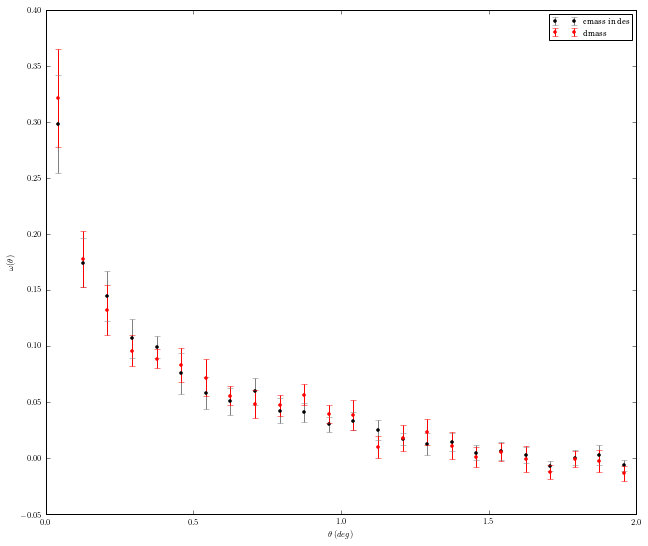

In [207]:
#------------------------------------------------------------
# Plot the results
#corr = [r_corr, b_corr]
#corr_err = [r_corr_err, b_corr_err]
#bootstraps = [r_bootstraps, b_bootstraps]



labels = '$CMASS~in~st82$\n$N=%i$' % len(cmass)

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

ax = fig.add_subplot(111, xscale='linear', yscale='linear')

#ax.errorbar(bin_centers_log, c_corr, c_corr_err,
#            fmt='.k', ecolor='gray', lw=1, label = 'cmass in des')
#ax.errorbar(bin_centers_log, d_corr, d_corr_err,
#            fmt='.r', ecolor='red', lw=1, label='dmass')
ax.errorbar(bin_centers, c_corr2, c_corr_err2,
            fmt='.k', ecolor='gray', lw=1, label = 'cmass in des')
ax.errorbar(bin_centers, d_corr2, d_corr_err2,
            fmt='.r', ecolor='red', lw=1, label='dmass')
#ax.errorbar(bin_centers, d_corr, d_corr_err,
#            fmt='.b', ecolor='blue', lw=1, label='cmass in des')

#t = np.array([0.01, 10])
#ax.plot(t, 10 * (t / 0.0005) ** -0.7, ':k', linewidth=1)

#ax.text(0.95, 0.95, labels,
#        ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$\theta\ (deg)$')
ax.set_ylabel(r'$\omega(\theta)$')
#ax.set_xscale('linear')
#if i == 0:
#    ax.set_ylabel(r'$\hat{w}(\theta)$')
ax.legend(loc='best')
ax.set_xlim(0, 2)     
plt.show()

fig.savefig('figure/acf_comparison_even.png')

In [21]:
def plot_z_distribution( cats = None, labels = None, suffix = 'test' ):
    
    import matplotlib.pyplot as plt
    z_bin, s = np.linspace(1e-5, 1.0, 200, retstep=True)
    z_center = z_bin[:-1]+s/2.
    
    fig, axes = plt.subplots( 1, 1, figsize = (8,5))
    N, _= np.histogram(cats['DESDM_ZP'], bins = z_bin)
    
    n = N/ST82Maparea

    axes.bar(z_center, n, s, color='b' )
    axes.set_xlabel('photo_z')
    axes.set_ylabel('n(z)')
    #ax.set_yscale('log')
    axes.legend(loc='best')

    axes.set_title('\nredshift histogram')
    figname ='figure/hist_z_'+suffix+'.png'
    fig.savefig(figname)
    print 'saving fig to ',figname
    
    DAT = np.column_stack((z_center, n))
    filename = 'data_txt/z_distribution_'+suffix+'.txt'
    np.savetxt(filename, DAT, header = 'z, n(z)')
    print 'saving data to ',filename

saving fig to  figure/hist_z_dmass_st82.png
saving data to  data_txt/z_distribution_dmass_st82.txt


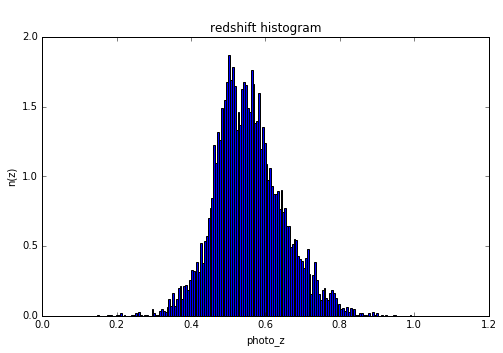

In [20]:
plot_z_distribution( cats = dmass_st82, labels = 'dmass_st82', suffix = 'dmass_st82' )

In [ ]:
plot_z_distribution( cats = dmass_st82, labels = '_dmass_st82', suffix = 'dmass_st82_binedge' )

In [60]:
dmass_st82.shape

(7564,)

In [133]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    mu, sigma = np.mean(data['DESDM_ZP']), np.std(data['DESDM_ZP'])
    z_R = np.random.normal(mu, sigma, size)
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float'), ('DESDM_ZP', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
    data_R['DESDM_ZP'] = z_R
                              
    return data_R

data_R = uniform_random_on_sphere(dmass_st82, size = 100 * dmass_st82.size)
data_R = Cuts.keepGoodRegion(data_R)
data_R_t = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
data_R_t = Cuts.keepGoodRegion(data_R_t)

In [110]:
data_R.size, dmass_st82.size

(575807, 7564)

In [114]:
from systematics_module.corr import angular_correlation
angular_correlation(data = dmass_st82, rand = data_R, weight = None, suffix = '_dmass_st82', out = None)
angular_correlation(data = clean_cmass_data_des, rand = data_R_t, weight = None, suffix = '_cmass_st82', out = None)

calculate angular correlation function
X (300, 2)  centers (30, 2)  tol=1e-05  maxiter=200
9 iterations  cluster sizes: [ 7 16 18  9  5 14  8  9  5 15  9  9 11 10 14 11 12 18  9  6  9  8  4  7  9
  7 10  8 11 12]
X (7564, 2)  centers (30, 2)  tol=1e-05  maxiter=200
75 iterations  cluster sizes: [302 361 360 149 159 244 231 260 212 277 363 206 245 302 179 267 213 323
 325 208 209 231 216 208 239 161 243 292 301 278]
saving data file to :  data_txt/acf_comparison_dmass_st82.txt
calculate angular correlation function
X (300, 2)  centers (30, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [24 16  5  5  8 11  3 10  7  8 18  9  3 12  8  7  7  8  7 12 13  6 14  7  6
 21  5  7 18 15]
X (8013, 2)  centers (30, 2)  tol=1e-05  maxiter=200
78 iterations  cluster sizes: [425 345 135 268 254 257 198 265 341 264 268 212 192 272 290 275 368 238
 365 293 291 233 182 246 293 278 160 215 282 308]
saving data file to :  data_txt/acf_comparison_cmass_st82.txt


0

In [115]:
DAT = np.loadtxt('data_txt/acf_comparison_dmass_st82.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]
DAT2 = np.loadtxt('data_txt/acf_comparison_cmass_st82.txt')
meanr2, xi2, xi_err2 = [DAT2[:,i] for i in range(3)]
print DAT

[[  4.75622923e-02   1.98527299e-01   7.23450349e-02]
 [  5.95735917e-02   1.05857921e-01   5.51298715e-02]
 [  7.49705238e-02   1.39484907e-01   3.27807555e-02]
 [  9.40332834e-02   9.01407601e-02   4.11311830e-02]
 [  1.18809198e-01   9.96324876e-02   2.64148285e-02]
 [  1.49514395e-01   1.01459637e-01   2.66591897e-02]
 [  1.88137421e-01   5.35880020e-02   2.29104788e-02]
 [  2.36777528e-01   5.38897250e-02   2.37350815e-02]
 [  2.98015323e-01   2.87036290e-02   1.32216190e-02]
 [  3.75271521e-01   3.04660219e-02   2.09212846e-02]
 [  4.72578917e-01   4.01029124e-02   1.94887369e-02]
 [  5.94734524e-01   1.10201600e-02   1.69557085e-02]
 [  7.48467997e-01   2.04154742e-02   1.75261865e-02]
 [  9.41856116e-01   1.03631282e-02   1.25646825e-02]
 [  1.18601246e+00   1.27935469e-02   1.84526208e-02]
 [  1.49157363e+00  -2.71682995e-03   2.10311429e-02]
 [  1.87608897e+00  -6.16829870e-03   2.34911280e-02]
 [  2.36002107e+00  -1.65452310e-03   1.07857442e-02]
 [  2.96586651e+00  -1.14282

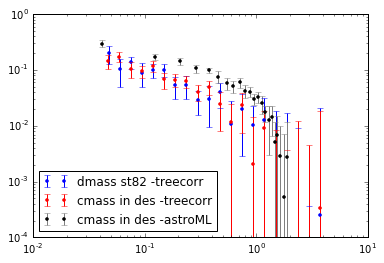

In [116]:
fig, ax = plt.subplots()
ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.b', label='dmass st82 -treecorr')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass in des -treecorr')
ax.errorbar(bin_centers, c_corr2, c_corr_err2,
            fmt='.k', ecolor='gray', lw=1, label = 'cmass in des -astroML')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best')

In [ ]:
source_R = uniform_random_on_sphere(shear, size = shear.size)
source_R = Cuts.keepGoodRegion(source_R)

In [192]:
from systematics_module.corr import LensingSignal, cross_angular_correlation, angular_correlation
LensingSignal(lense = clean_cmass_data_des, source = shear, rand = data_R, suffix = 'cmass')
LensingSignal(lense = dmass_st82, source = shear, rand = data_R, suffix = 'dmass')

Calculating lensing signal 
z_l = (0.45, 0.55)  z_s = (0.7, 1.0)
X (179, 2)  centers (10, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [13 19 13 26 16 12 21 14 25 20]
X (8013, 2)  centers (10, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [811 668 827 863 702 770 830 826 919 797]
saving data file to :  data_txt/lensing_cmass.txt
Calculating lensing signal 
z_l = (0.45, 0.55)  z_s = (0.7, 1.0)
X (173, 2)  centers (10, 2)  tol=1e-05  maxiter=200
9 iterations  cluster sizes: [17  6 15 24 16 15 16 21 28 15]
X (7564, 2)  centers (10, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [ 662  521  501  913  958  621  714  763 1090  821]
saving data file to :  data_txt/lensing_dmass.txt


saving fig to : figure/lensing_comparison.png


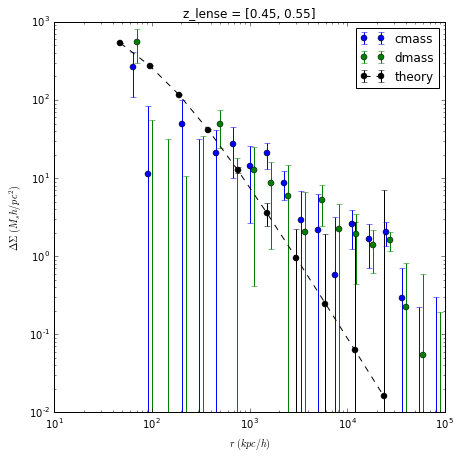

In [193]:
# plotting

labels = ['cmass', 'dmass']
lensingdat = [np.loadtxt('data_txt/lensing_'+s+'.txt') for s in labels ]

#r_p_bins, LensSignal, LSjkerr, correctedLensSignal, CLSjkerr, BoostFactor, Boostjkerr = lensingdat[:,0], lensingdat[:,1],lensingdat[:,2],lensingdat[:,3],lensingdat[:,4],lensingdat[:,5],lensingdat[:,6]
fig, ax = plt.subplots(1,1, figsize = (7,7))

for j in range(len(labels)):

    r_p_bins, LensSignal, LSjkerr = [lensingdat[j][:,i] for i in range(lensingdat[0][0].size)]
    ax.errorbar(r_p_bins * (1 + 0.1*j), LensSignal, yerr = LSjkerr, fmt='o', label = labels[j])

theory = np.loadtxt('data_txt/smd_v_theta_cmass.dat')
rr_the = theory[:,0]
delta_sigma_the = theory[:,1]
error_the = theory[:,2] * np.sqrt(5000/120)
ax.errorbar(10**rr_the, 10**delta_sigma_the, yerr = 10**error_the, color = 'black', fmt='--o', label = 'theory')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 1e5)
ax.set_ylim(1e-2,1e3)
ax.set_xlabel(r'$r$ $(kpc/h)$')
ax.set_ylabel(r'$\Delta\Sigma$ $(M_{s}h/pc^{2})$')
ax.set_title('z_lense = [0.45, 0.55]'  )
ax.legend(loc = 'best')

figname='figure/lensing_comparison.png'
fig.savefig(figname)
print 'saving fig to :', figname